# Courbe ROC et AUC

## Introduction

En plus des métriques de precision, recall et F1 score, il existe un autre outil qui permet de mesurer les performances d'un modèle de classification : la courbe ROC (ROC Curve).

La courbe ROC et sa mesure associée l'AUC (Aire sous la courbe) permettent d'évaluer les performances globales d'un modèle mais aussi de comparer facilement les performances de plusieurs modèles de classifications entre eux. 

La courbe ROC est donc un outil qui peut faciliter notre décision concernant le choix du modèle de classification à utiliser.

## Partie théorique 

Lorsqu'un modèle de classification fait une prédiction sur une observation, il va lui attribuer une classe. 

Par exemple si notre modèle doit prédire si un signal radar provient d'un avion ou d'un nuage, alors les classes seront avion et nuage. La classe positive (1) est généralement celle qu'on cherche à détecter. Dans cette exemple la classe avion sera la classe positive. La classe nuage sera donc la classe négative (0). 

Pour choisir dans quelle classe placer une observation, le modèle va utiliser le score de la fonction de décision. Plus ce score est élevé, plus la prédiction est susceptible d'être positive. C'est une estimation de la probabilité que ce qu'on doit prédire soit positif.

Afin de choisir comment classer les observations entre ces deux classes on va utiliser un **seuil** ou **threshold**. Si le score de la fonction de décision est supérieur au seuil, alors l'observation sera prédite comme positive (avion), si elle est inférieur, alors elle sera prédite comme négative (nuage).

<img src="imgs/threshold.PNG">

Sur cette image est représentée la classe réelle des observations (nuage ou avion). La ligne noire représente le seuil. Les observations ayant un score supérieur à ce seuil sont prédites comme positives par le modèle.

En déplaçant ce seuil, on va modifier la capacité de notre modèle à détecter la classe positive. Lorsque l'on baisse ce seuil, notre modèle va classer un plus grand nombre d'observations comme positives. A l'inverse, lorsque l'on monte le seuil notre modèle va classer un moins grand nombre d'observations comme positives.

On va utiliser ce seuil pour tracer la courbe ROC, qui est un outil pour mesurer les performances globales d'un modèle de classification.

Pour obtenir la courbe ROC, on fait varier le seuil, et pour chaque valeur du seuil on place un point correspondant à l’intersection entre le TPR et le FPR sur un graphique.

- Le **TPR**, ou taux de vrai positif, est un autre nom pour le recall. Il correspond aux nombres de prédictions positives correctes parmi toutes les observations positives. Dans notre exemple, le nombre de prédictions d'avions correctes parmi le nombre total d'observations d'avions.

- Le **FPR**, ou taux de faux positif, correspond aux nombres de prédictions positives incorrectes parmi les observations négatives. Dans notre exemple, le nombre de prédictions d'avions incorrectes parmi le nombre total d'observations de nuages.

En plaçant toutes les combinaisons on obtient la courbe ROC.

<img src="imgs/creating-roc.PNG">

Sur ce graphique le point mis en avant avec le TPR à 0.8 et le FPR à 0.4 correspond au seuil de l'image précédente.

Si on défini le seuil de notre modèle au minimum, alors toutes les observations seront classées comme positives → TPR de 1, mais FPR de 1 également.

A l’inverse si le seuil de notre modèle est au maximum, alors toutes les observations seront classés comme négatives → TPR de 0 et FPR de 0.

L’objectif est donc de trouver le seuil pour maximiser notre taux de vrai positif et minimiser notre taux de faux positif. En modifiant le seuil on affecte les performances de notre modèle.

L’intérêt de la courbe ROC est de voir les performances du modèle et d’ajuster le seuil en fonction, mais aussi de comparer les performances du modèle avec celles des autres modèles.

<img src="imgs/roc-curves.png">

L’objectif est que la courbe ROC du modèle se rapproche le plus possible de la courbe parfaite. En revanche une courbe ROC ressemblant à celle de la courbe parfaite peut aussi être le signe d’overfitting ou de data leaking.

L'AUC ou aire sous la courbe, est une mesure complémentaire à la courbe ROC. L’AUC permet aussi d’évaluer la performance d’un modèle. 
Elle correspond à l’aire sous la courbe ROC. Plus l’AUC est élevée, meilleur est le modèle.

L’AUC évalue les performances globales du modèle, en s’intéressant à toute les combinaisons possibles produites avec le seuil, pour donner un score. En revanche l’AUC ne tient pas compte du type d’erreur pouvant être fait par le modèle, tout comme la courbe ROC.

<img src="imgs/auc.PNG">

La courbe ROC et l'AUC sont des métriques utiles lorsque l'on s'intéresse aux performances globales des modèles, que les classes sont assez équilibrées et que l'on ne s'intéresse pas à un type d'erreur en particulier.

## Partie pratique

### Création d'un jeu de données pour la classification

In [1]:
# Importation des librairies

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_predict

/tmp/ipykernel_1937/3317723390.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Création d'un jeu de données avec deux classes à prédire

X, y = make_classification(n_samples=10000, n_features=10, n_informative=3, n_classes=2, weights= [0.6, 0.4], flip_y=0.1, random_state=42)

`make_classification` est une fonction qui permet de créer un jeu de données fictif, dont on peut modifier les paramètres. 

On va conserver l'exemple d'un modèle devant prédire si une observation est un nuage ou un avion selon le signal radio reçu. Le nombre d'observations est de 10 000, 6000 sont des observations de nuages et 4000 d'avions. La classe positive (1) sera la classe avion.

In [3]:
# Création des train et test set

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.8, random_state=42, stratify=y)

### Entrainement du modèle

On va entrainer deux modèles, un decision tree et un random forest. Le modèle random forest servira de comparaison pour montrer l'intérêt de la courbe ROC et AUC.

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Entrainement de plusieurs modèles de classifications
tr_clf = DecisionTreeClassifier(random_state=42)
tr_clf.fit(X_train, y_train)

rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)

# On sauvegarde les prédictions faites sur le training set pour les modèles
y_train_pred_tr = cross_val_predict(tr_clf, X_train, y_train)
y_train_pred_rf = cross_val_predict(rf_clf, X_train, y_train)

Ici on réalise les prédictions sur le training set car on va chercher à ajuster au mieux nos hyperparamètres dont le seuil de classification (c'est possible grâce à la cross validation). Lorsque l'on sera satisfait du modèle on pourra l'évaluer sur le testing set.

### Rappel sur les métriques

Lorsque l'on souhaite mesurer les performances d'un modèle de classification on dispose de plusieurs métriques : 

- L'accuracy -> Le nombre total de prédictions correctes parmi toutes les observations
- Le recall -> Le nombre prédictions positives correctes parmi toutes les observations positives
- La precision -> le nombre de prédictions positives correctes parmi les prédictions positives
- Le F1 score -> Une combinaison entre le recall et la precision

On peut également représenter les prédictions du modèle dans une matrice de confusion, qui permet de mieux comprendre les prédictions faites par le modèle et ses erreurs.

In [5]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, precision_recall_curve

# On crée la matrice de confusion en passant les classes et les prédictions du modèle
cm = confusion_matrix(y_train, y_train_pred_rf)
conf_matrix = pd.DataFrame(cm, index=["Actual Cloud (0)", "Actual Plane (1)"], columns=["Predicted Cloud (0)", "Predicted Plane (1)"])

display(conf_matrix)

print("Score de l'accuracy : ", accuracy_score(y_train, y_train_pred_tr))
print("Score du recall : ", recall_score(y_train, y_train_pred_tr))
print("Score de la precision : ", precision_score(y_train, y_train_pred_tr))
print("Score F1 : ", f1_score(y_train, y_train_pred_tr))

,Predicted Cloud (0),Predicted Plane (1)
Actual Cloud (0),4434,256
Actual Plane (1),444,2866


Score de l'accuracy :  0.844375
Score du recall :  0.8105740181268882
Score de la precision :  0.8127840048470161
Score F1 :  0.8116775071849947


Il existe une fonction dans sklearn qui nous permet d'obtenir ces différentes métriques. Cette fonction  permet également de voir les métriques pour nos deux classes.

In [6]:
from sklearn.metrics import classification_report

print(classification_report(y_train, y_train_pred_tr))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      4690
           1       0.81      0.81      0.81      3310

    accuracy                           0.84      8000
   macro avg       0.84      0.84      0.84      8000
weighted avg       0.84      0.84      0.84      8000



On peut aussi visualiser sur un graphique l'évolution de la précision et du recall en fonction du seuil. 

In [7]:
# Au lieu d'obtenir les prédictions, on récupere les scores de probabilités pour chaque observations
y_probas_tr = cross_val_predict(tr_clf, X_train, y_train, method="predict_proba")
display(y_probas_tr)

# On récupere uniquement les probabilités pour la classe positive
y_scores_tr = y_probas_tr[:, 1]

# A partir des scores de décisions on calcule les combinaisons de scores pour recall et precision en fonction du seuil
precisions_tr, recalls_tr, thresholds_tr = precision_recall_curve(y_train, y_scores_tr)

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

La fonction `cross_val_predict` peut être utilisé avec le paramètre `method=`, afin d'obtenir les scores de probabilités pour chaque classe ou alors les scores de la fonction décision.

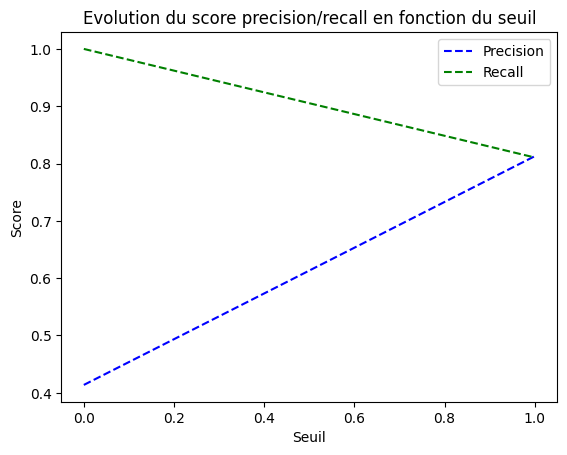

In [8]:
plt.plot(thresholds_tr, precisions_tr[:-1], "b--", label="Precision")
plt.plot(thresholds_tr, recalls_tr[:-1], "g--", label="Recall")
plt.title("Evolution du score precision/recall en fonction du seuil")
plt.xlabel("Seuil")
plt.ylabel("Score")
plt.legend()
plt.show()

On peut également représenter l'évolution de la precision en fonction du recall.

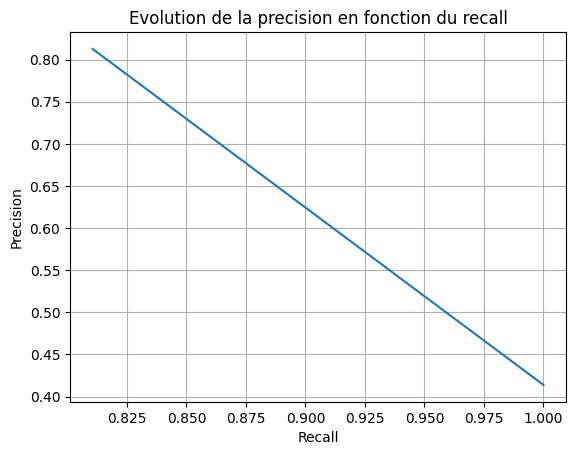

In [9]:
plt.plot(recalls_tr[:-1], precisions_tr[:-1])

plt.title("Evolution de la precision en fonction du recall")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.show()

Lorsque l'on augmente le recall, on diminue la precision. 

Lorsque l'on a un problème de classification pour lequel on ne s'intéresse pas au type d'erreur, alors on va chercher à trouver un équilibre entre les deux. 
En revanche lorsqu'un type d'erreur à une importance plus grande qu'un autre type d'erreur, alors on va chercher à maximiser soit le recall, soit la precision.

Dans notre exemple de détection d'avion, on va chercher à maximiser le nombre de prédictions positives correctes, les vrai positifs (ou minimiser le nombre de prédictions négatives incorrectes, les faux négatifs). On ne souhaite pas que le modèle prédise un nuage alors que c'est en réalité un avion. On va chercher à maximiser le recall.

Dans le cas ou on cherche à minimiser le nombre de prédictions positifs incorrectes, les faux positifs, alors on va chercher à maximiser la precision.

maximiser le recall -> diminuer le nombre de faux négatifs

maximiser la precision -> diminuer le nombre de faux positifs

### Choix d'un seuil suivant un score de métrique

Lorsque l'on cherche à optimiser une métrique plutôt qu'une autre on va vouloir diminuer ou augmenter notre seuil.
Dans le cas ou on souhaite augmenter la precision, on augmente le seuil.
Dans le cas ou on souhaite augmenter le recall, on diminue le seuil.

Voici le code si on souhaite obtenir un score de recall de 0,9.

In [10]:
# On cherche dans recalls l'index de la première valeur inférieur à 0.91
index_90_recall_tr = np.argmax(recalls_tr <= 0.91)

# On récupère le seuil associé à l'index 
treshold_90_recall_tr = thresholds_tr[index_90_recall_tr]

print("Seuil pour obtenir un recall de 90% : ", treshold_90_recall_tr)

# On crée de nouvelle prédictions ou la classe sera positive si son score est supérieur au seuil permettant d'avoir un recall de 0.9
y_train_pred_90_tr = (y_scores_tr >= treshold_90_recall_tr)

print("score du recall", recall_score(y_train, y_train_pred_90_tr))
print("score de precision", precision_score(y_train, y_train_pred_90_tr))

Seuil pour obtenir un recall de 90% :  1.0
score du recall 0.8105740181268882
score de precision 0.8127840048470161


Dans ce cas précis on obtient le même résultat qu'auparavant pour le recall. C'est du à l'utilisation de d'un decision tree, si on print recalls ou thresold, on se rend compte qu'il n'y a que 3 valeurs. 

Ici on utilise `recalls_tr <= 0.91` car les valeurs pour recalls sont dans un ordre décroissant. Si on recherche un score de precision supérieur à 0.9 alors il faut utiliser `precisions_tr >= 0.9` car les valeurs pour precisions sont dans un ordre croissant.

### Courbe ROC 

On va maintenant représenter la courbe ROC. Pour rappel la courbe ROC est obtenue en variant le seuil donnant différentes valeurs de scores pour le TPR (taux de vrai positif, le recall) et le FPR (taux de faux positif).

In [11]:
from sklearn.metrics import roc_curve

# La fonction roc_curve retourne le FPR, TPR et les seuils 
fpr_tr, tpr_tr, tresholds_tr = roc_curve(y_train, y_scores_tr)

In [12]:
# Fonction pour représenter la courbe ROC
def plot_roc_curve(fpr, tpr, label=None):

    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], "k--")
    plt.title("Courbe ROC")
    plt.xlabel("Taux de Faux Positif")
    plt.ylabel("Taux de Vrai Positif")
    plt.grid()

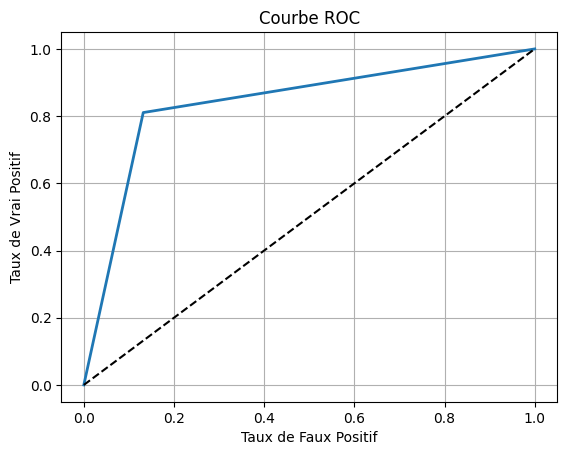

In [13]:
plot_roc_curve(fpr_tr, tpr_tr)
plt.show()

La courbe ROC pour le modèle Decision Tree est bien au-dessus de la courbe du random classifier. Le modèle est performant pour notre problème de classification.

### AUC

On peut calculer l'aire sous la courbe ROC.

In [14]:
from sklearn.metrics import roc_auc_score

display(roc_auc_score(y_train, y_scores_tr))

0.8394021476561947

Pour le modèle Decision Tree on a donc une AUC de 0.83.

### Comparaison de modèle avec ROC et AUC

L'intérêt de la courbe ROC et de l'AUC est de pouvoir comparer les performances de plusieurs modèles entre eux. 
Ici on va reprendre le modèle utilisé et le comparer avec un le modèle random forest.

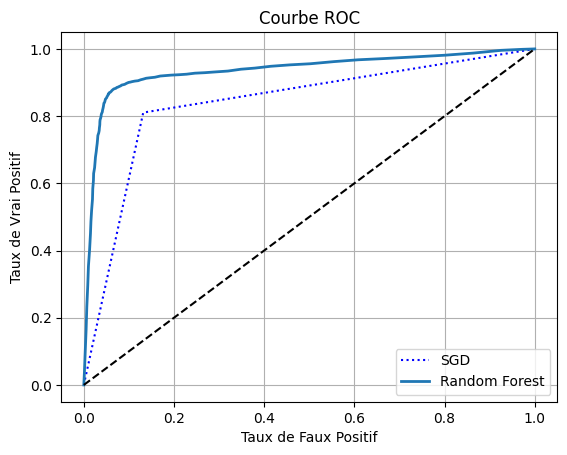

AUC modèle SGD 0.8394021476561947
AUC modèle Random Forest 0.9356157280064933


In [15]:
# On récupere les scores pour le modèle random forest
y_probas_rf = cross_val_predict(rf_clf, X_train, y_train, cv=5, method="predict_proba")
y_scores_rf = y_probas_rf[:, 1]

# On calcule le TPR et FPR pour le modèle random forest
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_train, y_scores_rf)

# On représente graphiquement les deux modèles
plt.plot(fpr_tr, tpr_tr, "b:", label="SGD")
plot_roc_curve(fpr_rf, tpr_rf, "Random Forest")
plt.legend(loc="lower right")
plt.show()

print("AUC modèle SGD", roc_auc_score(y_train, y_scores_tr))
print("AUC modèle Random Forest", roc_auc_score(y_train, y_scores_rf))

On se rend compte ici que le modèle Random Forest est plus performant que le modèle Decision Tree. La courbe ROC pour le modèle Random Forest est toujours au-dessus de celle du Decision Tree. C'est confirmé par l'AUC avec un écart de 0.1 entre les deux modèles.